In [1]:
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA


url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
data = pd.read_csv(url)

df = data.drop(columns=['Channel', 'Region'])

print("Shape:", df.shape)
df.head()


Shape: (440, 6)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [2]:
def no_processing(data): return data.copy()

def normalize(data):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

def transform(data):
    pt = PowerTransformer()
    return pd.DataFrame(pt.fit_transform(data), columns=data.columns)

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pd.DataFrame(pca.fit_transform(data), columns=[f'PC{i+1}' for i in range(n_components)])

# Combined Techniques
def T_plus_N(data):
    return normalize(transform(data))

def T_plus_N_plus_PCA(data):
    return apply_pca(T_plus_N(data))


In [3]:
def evaluate_clustering(X, labels):
    if len(set(labels)) == 1:  # Avoid degenerate cases
        return 0, 0, 0
    sil = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, calinski, db



In [9]:

from sklearn.cluster import DBSCAN, OPTICS, Birch, SpectralClustering
methods = {
    "KMeans": lambda X, c: KMeans(n_clusters=c, random_state=42).fit_predict(X),
    "Hierarchical": lambda X, c: AgglomerativeClustering(n_clusters=c).fit_predict(X),
    "MeanShift": lambda X, _: MeanShift(bandwidth=estimate_bandwidth(X)).fit_predict(X),  "DBSCAN": lambda X, _: DBSCAN(eps=1.5, min_samples=5).fit_predict(X),
    "OPTICS": lambda X, _: OPTICS(min_samples=5).fit_predict(X),
    "Birch": lambda X, c: Birch(n_clusters=c).fit_predict(X),
    "SpectralClustering": lambda X, c: SpectralClustering(n_clusters=c, affinity='nearest_neighbors').fit_predict(X)
}


preprocessings = {
    "No Data Processing": no_processing,
    "Normalization": normalize,
    "Transform": transform,
    "PCA": lambda X: apply_pca(normalize(X)),
    "T+N": T_plus_N,
    "T+N+PCA": T_plus_N_plus_PCA
}


results = []

for method_name, cluster_func in methods.items():
    for prep_name, prep_func in preprocessings.items():
        X_prep = prep_func(df)
        cluster_range = [3, 4, 5] if method_name not in ["MeanShift", "DBSCAN", "OPTICS"] else [None]

        for c in cluster_range:
            try:
                labels = cluster_func(X_prep, c)
                sil, calinski, db = evaluate_clustering(X_prep, labels)
                results.append({
                    'Method': method_name,
                    'Preprocessing': prep_name,
                    'Clusters': c if c else len(set(labels)),
                    'Silhouette': round(sil, 3),
                    'Calinski-Harabasz': round(calinski, 1),
                    'Davies-Bouldin': round(db, 2)
                })
            except Exception as e:
                results.append({
                    'Method': method_name,
                    'Preprocessing': prep_name,
                    'Clusters': c,
                    'Silhouette': 'NA',
                    'Calinski-Harabasz': 'NA',
                    'Davies-Bouldin': 'NA'
                })

results_df = pd.DataFrame(results)



In [10]:

results_df['Clusters'] = results_df['Clusters'].apply(lambda x: str(x) if x is not None else 'auto')
pivot = results_df.pivot_table(index=['Method', 'Preprocessing'],
                               columns='Clusters',
                               values=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
                               aggfunc='first')
pivot


Calinski-Harabasz                   \
Clusters                                              1   10    11    14   
Method             Preprocessing                                           
Birch              No Data Processing               NaN  NaN   NaN   NaN   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN   NaN   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   
DBSCAN             No Data Processing               0.0  NaN   NaN   NaN   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN   NaN   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   
Hierarchical       No Data Processing               NaN  NaN   NaN   NaN   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN   NaN   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   
KMeans             No Data Processing               NaN  NaN   NaN   NaN   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN   NaN   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   
MeanShift          No Data Processing               NaN  NaN   NaN  54.8   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN  93.9   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   
OPTICS             No Data Processing               NaN  5.9   NaN   NaN   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN   NaN   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   
SpectralClustering No Data Processing               NaN  NaN   NaN   NaN   
                   Normalization                    NaN  NaN   NaN   NaN   
                   PCA                              NaN  NaN   NaN   NaN   
                   T+N                              NaN  NaN   NaN   NaN   
                   T+N+PCA                          NaN  NaN   NaN   NaN   
                   Transform                        NaN  NaN   NaN   NaN   

                                                                              \
Clusters                                 15      2   23      3      4      5   
Method             Preprocessing                                               
Birch              No Data Processing   NaN    NaN  NaN  183.4  185.3  197.0   
                   Normalization        NaN    NaN  NaN  130.2  128.4  131.6   
                   PCA                  NaN    NaN  NaN  173.6  154.6  254.5   
                   T+N                  NaN    NaN  NaN  137.7  116.2  102.6   
                   T+N+PCA              NaN    NaN  NaN  

In [12]:
def visualize_clustering(method_name, X, n_clusters=None):
    if method_name == "KMeans":
        labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X)
    elif method_name == "Hierarchical":
        labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X)
    elif method_name == "MeanShift":
        labels = MeanShift(bandwidth=estimate_bandwidth(X)).fit_predict(X)
    elif method_name == "DBSCAN":
        labels = DBSCAN(eps=1.5, min_samples=5).fit_predict(X)
    elif method_name == "OPTICS":
        labels = OPTICS(min_samples=5).fit_predict(X)
    elif method_name == "Birch":
        labels = Birch(n_clusters=n_clusters).fit_predict(X)
    elif method_name == "SpectralClustering":
        labels = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors').fit_predict(X)
    else:
        print(f"Unknown method: {method_name}")
        return

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='tab10', s=50)
    plt.title(f"{method_name} Clustering (c={n_clusters if n_clusters else 'auto'})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()


In [13]:
X_pca = apply_pca(normalize(df))


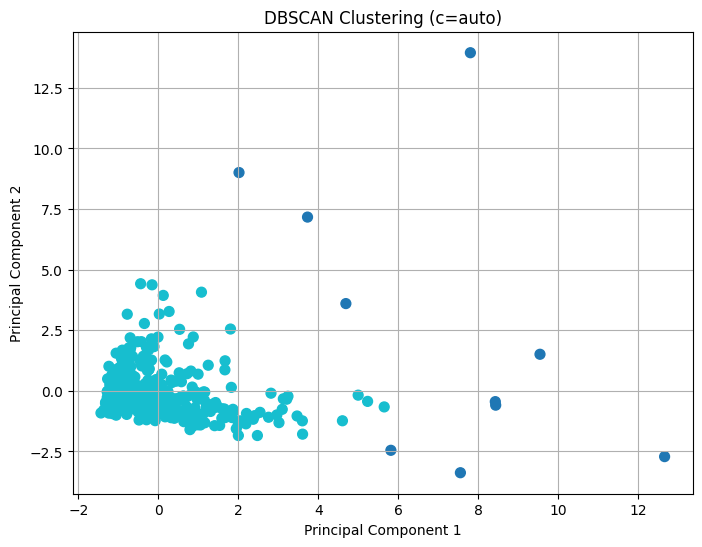

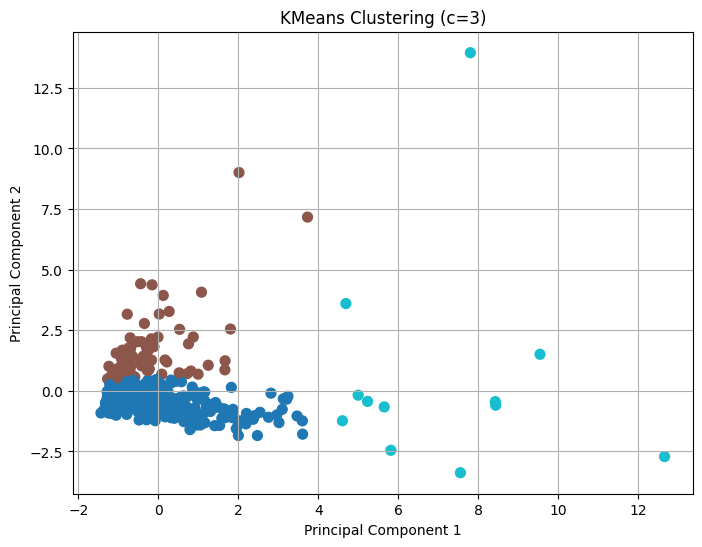

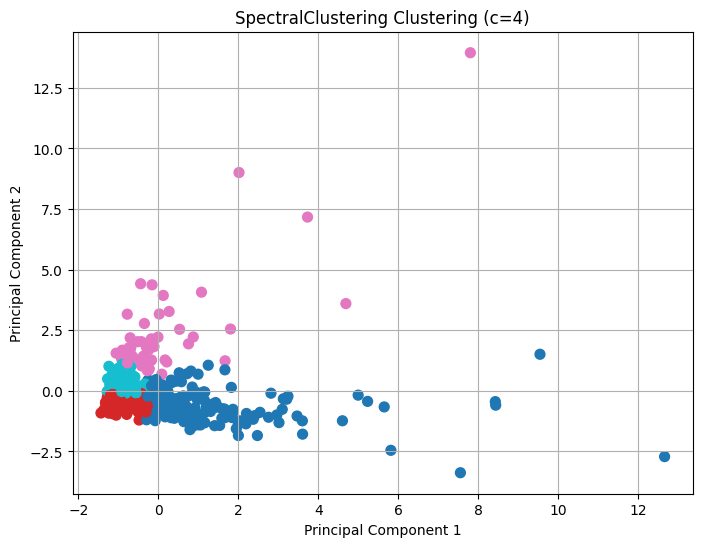

In [14]:
visualize_clustering("DBSCAN", X_pca)
visualize_clustering("KMeans", X_pca, n_clusters=3)
visualize_clustering("SpectralClustering", X_pca, n_clusters=4)
